In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

In [184]:
from tqdm.auto import tqdm
import pickle
import os

In [2]:
from run_functions import *
from agent_functions import *
from plot_functions import *

In [3]:
from routing_networks import *
from recommenders import *

In [4]:
import math

In [5]:
def average_rolled_q_tables(Q, neighborhood):
    # creates an array where sucessive rows are "rolled" versions of Q, along the axis of agents
    tmp_Q = np.array([np.roll(Q, shift=i, axis=0) for i in range(neighborhood)])
    Q = np.mean(tmp_Q, axis=0)
    return Q

In [272]:
def follow_the_regularized_leader_select_action(Q, S):
    ## DETERMINE ACTIONS
    indices = np.arange(len(S))
    regularization = np.exp(Q[indices, S])/np.exp(Q[indices, S]).sum()
    x = Q[indices, S] - regularization
    A = np.argmax(x, axis=1)
    return A

In [283]:
def softmax_select_action(Q, S):
    indices = np.arange(len(S))
    p = np.exp(Q[indices, S])/np.exp(Q[indices, S]).sum()
    rng = np.random.default_rng()
    A = rng.choice(np.arange(3), 1, p=p)

In [290]:
indices = np.arange(len(S))
p = np.exp(Q[indices, S])/np.exp(Q[indices, S]).sum()
rng = np.random.default_rng()
A = rng.choice(np.broadcast_to(np.arange(3), shape=(100, 3)), 1, p=p)

ValueError: p must be 1-dimensional

In [268]:
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

In [269]:
a = follow_the_regularized_leader_select_action(Q, S)

(100, 3)
(100, 3)


In [270]:
a

array([1, 0, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1,
       1, 1, 1, 2, 2, 1, 0, 2, 0, 2, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 0, 2,
       1, 1, 0, 2, 1, 2, 0, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2,
       0, 1, 2, 1, 1, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 1, 1, 2, 2,
       2, 1, 2, 0, 1, 0, 1, 1, 0, 2, 1, 0])

In [6]:
def braess_augmented_network(A, u=1, d=1, c=0):
    n_agents = len(A)
    n_up = (A == 0).sum()
    n_down = (A == 1).sum()
    n_cross = (A == 2).sum()

    r_0 = u + (n_up + n_cross) / n_agents
    r_1 = d + (n_down + n_cross) / n_agents
    r_2 = c + (n_up + n_cross) / n_agents + (n_down + n_cross) / n_agents
    T = [-r_0, -r_1, -r_2]

    R = np.array([T[a] for a in A])  # -1 * np.vectorize(dict_map.get)(A)
    return R, T

In [273]:
N_AGENTS = 100
N_STATES = 1
N_ACTIONS = 3
N_ITER = 1000

EPSILON = 0.05
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.1

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])

In [280]:
%%time
Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

if ALPHA == "UNIFORM":
    ALPHA = np.random.random_sample(size=N_AGENTS)

if EPSILON == "UNIFORM":
    EPSILON = np.random.random_sample(size=N_AGENTS) * mask
else:
    EPSILON = EPSILON * np.ones(N_AGENTS) * mask

EPS_START = 0.9
EPS_END = 0.001
EPS_DECAY = N_ITER/16

M = {}
ind = np.arange(N_AGENTS)
S = np.random.randint(N_STATES, size=N_AGENTS)
R = np.ones(N_AGENTS) * -2
A = np.random.randint(N_STATES, size=N_AGENTS)

# c_costs = np.concatenate([np.zeros(int(N_ITER/2)), np.ones(int(N_ITER/2))])
# tmp = np.concatenate([np.zeros(100), np.ones(100)*1, np.ones(100)*2, np.ones(100)*0.5])
# c_costs = np.tile(tmp, int(N_ITER/len(tmp)))
# d_costs = np.concatenate([np.ones(int(N_ITER/2)), np.ones(int(N_ITER/2))*2])

elist = []

for t in range(N_ITER):
    
    EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
    elist.append(EPSILON)
    
    # S = heuristic_recommender(Q, N_AGENTS)
    
    # A = e_greedy_select_action(Q, S, EPSILON)
    A = follow_the_regularized_leader_select_action(Q, S)
    #alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)
    
    #R, travel_time_per_route = braess_augmented_network(A, 
    #                                                    c=0, 
    #                                                    d=d_costs[t], 
    #                                                    u=1
    #                                                   )
    
    R, travel_time_per_route = braess_augmented_network(A)
    
    # R = np.mean(R)
    
    Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
    
    Q = average_rolled_q_tables(Q, neighborhood=1)
    
    ### SAVE PROGRESS DATA
    M[t] = {"nA": np.bincount(A, minlength=3),
            "R": R,
            "Qmean": Q.mean(axis=1).mean(axis=0),
            #"groups": count_groups(Q[ind, S, :], 0.1),
            "Qvar": Q[ind, S, :].var(axis=0),
            "nA": np.bincount(A, minlength=3),
            "T": travel_time_per_route,
            "sum_of_belief_updates": sum_of_belief_updates,
            #"alignment": alignment,
            #"recommendation_alignment": recommendation_alignment,
            #"action_alignment": action_alignment,
            }

CPU times: user 109 ms, sys: 3.05 ms, total: 112 ms
Wall time: 110 ms


In [276]:
Q.shape

(100, 1, 3)

In [275]:
elist = np.array(elist)
elist = np.where(elist < 0.01, 0, elist)
argmin = np.argmin(elist)
print(argmin, elist[argmin])

288 0.0


Text(0, 0.5, 'Average Travel Time')

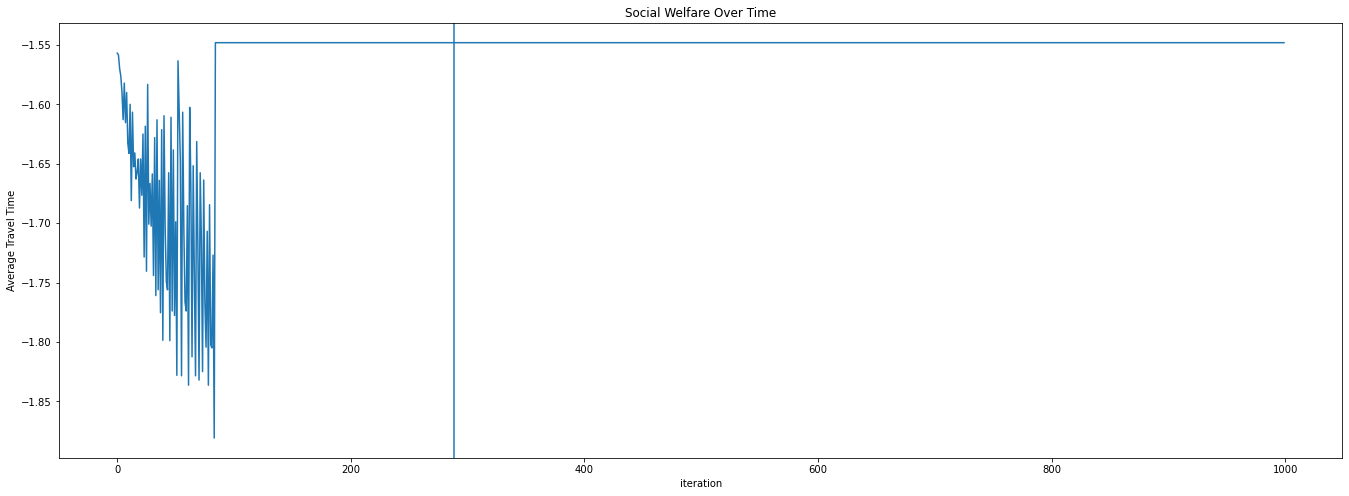

In [281]:
plt.figure(figsize=(23,8))
plt.plot([M[t]["R"].mean() for t in M.keys()])
plt.axvline(argmin)
plt.title("Social Welfare Over Time")
plt.xlabel("iteration")
plt.ylabel("Average Travel Time")

test_neighbour_roll_average


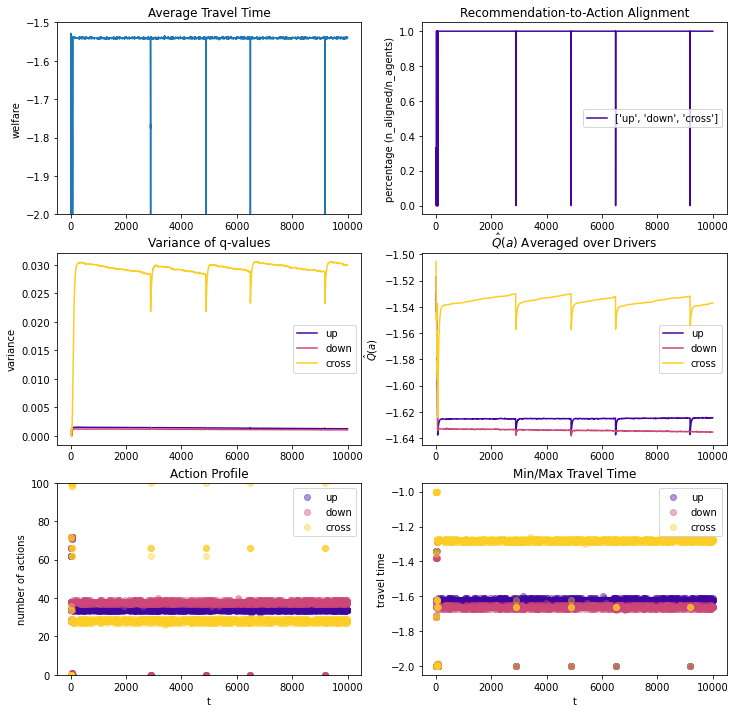

In [68]:
plot_run(M, "test_neighbour_roll_average", N_AGENTS, N_ACTIONS, N_ITER)

In [351]:
def run(N_ITER, QINIT, N_AGENTS, N_STATES, N_ACTIONS, ALPHA, EPSILON, EPS_DECAY, NEIGHBORHOOD=1):

    Q = initialize_q_table(QINIT, N_AGENTS, N_STATES, N_ACTIONS)

    if ALPHA == "UNIFORM":
        ALPHA = np.random.random_sample(size=N_AGENTS)

    if EPSILON == "UNIFORM":
        EPSILON = np.random.random_sample(size=N_AGENTS) * mask
    else:
        EPSILON = EPSILON * np.ones(N_AGENTS) * mask

    EPS_START = 0.9
    EPS_END = 0
    # EPS_DECAY = N_ITER/16

    M = {}
    ind = np.arange(N_AGENTS)
    S = np.random.randint(N_STATES, size=N_AGENTS)
    R = np.ones(N_AGENTS) * -2
    A = np.random.randint(N_STATES, size=N_AGENTS)

    # c_costs = np.concatenate([np.zeros(int(N_ITER/2)), np.ones(int(N_ITER/2))])
    tmp = np.concatenate([np.zeros(100), np.ones(100)*1, np.ones(100)*2, np.ones(100)*0.5])
    c_costs = np.tile(tmp, int(N_ITER/len(tmp)))
    d_costs = np.concatenate([np.ones(int(N_ITER/2)), np.ones(int(N_ITER/2))*2])

    elist = []

    for t in range(N_ITER):

        EPSILON = (EPS_END + (EPS_START - EPS_END) * math.exp(-1. * t / EPS_DECAY)) # if t < N_ITER/10 else 0
        elist.append(EPSILON)

        A = e_greedy_select_action(Q, S, EPSILON)

        # alignment, recommendation_alignment, action_alignment = calculate_alignment(Q, S, A)

        #R, travel_time_per_route = braess_augmented_network(A, 
        #                                                    c=0, 
        #                                                    d=d_costs[t], 
        #                                                    u=1
        #                                                   )

        # R, travel_time_per_route = braess_augmented_network(A)
        R, travel_time_per_route = braess_initial_network(A)

        # R = np.mean(R)

        Q, sum_of_belief_updates = bellman_update_q_table(Q, S, A, R, ALPHA, GAMMA)
        
        Q = average_rolled_q_tables(Q, neighborhood=NEIGHBORHOOD)
        
        ## SAVE PROGRESS DATA
        M[t] = {"nA": np.bincount(A, minlength=3),
                "R": R,
                "Qmean": Q.mean(axis=1).mean(axis=0),
                "groups": count_groups(Q[ind, S, :], 0.1),
                "Qvar": Q[ind, S, :].var(axis=0),
                "nA": np.bincount(A, minlength=3),
                "T": travel_time_per_route,
                "sum_of_belief_updates": sum_of_belief_updates,
                #"alignment": alignment,
                #"recommendation_alignment": recommendation_alignment,
                #"action_alignment": action_alignment,
               }
    return M

### averaging results for exponentially decreasing epsilons in braess paradox

In [79]:
results_dict = {}

for repetition in range(40):
    print(repetition)
    for denominator in [16]:
        EPS_DECAY = N_ITER/denominator
        M = run(N_ITER, QINIT, N_AGENTS, N_STATES, N_ACTIONS, ALPHA, EPSILON, EPS_DECAY)
        
        results_dict[repetition] = np.array([M[t]["R"].mean() for t in M.keys()])

NameError: name 'denominator' is not defined

In [ ]:
averaged_timeseries = np.array([results_dict[repetition] for repetition in range(40)]).mean(axis=0)
std_timeseries = np.array([results_dict[repetition] for repetition in range(40)]).std(axis=0)

In [ ]:
argmins = np.array([results_dict[repetition] for repetition in range(40)]).argmin(axis=1)

In [ ]:
min_argmin = argmins.min()
max_argmin = argmins.max()

In [ ]:
poa = averaged_timeseries/-1.5
poa_std = (np.array([results_dict[repetition] for repetition in range(40)])/-1.5).std(axis=0)

In [ ]:
x_vals = np.arange(len(poa))
x_samp = np.linspace(0, len(poa), 101)
y_vals = np.interp(x_samp, x_vals, poa)
y_std = np.interp(x_samp, x_vals, poa_std)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(x_samp, y_vals, color="blue")
plt.fill_between(x_samp, y_vals+y_std, y_vals-y_std, alpha=0.3)
plt.title("100 Q-learners in Braess Paradox (from randomly initialized Q-tables)")
plt.xlabel("iteration")
plt.ylabel("Price of Anarchy")
plt.axhline(y = 1.3)
plt.axhline(y = 1)
plt.annotate("social optimum", (0.8, 0.115), xycoords='figure fraction')
plt.annotate("nash prediction", (0.8, 0.905), xycoords='figure fraction')
#plt.axvline(x = min_argmin)
#plt.axvline(x = max_argmin)
plt.tight_layout()
plt.savefig("poa_decreasing_convergence.png", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(averaged_timeseries, color="blue")
plt.fill_between(np.arange(len(averaged_timeseries)), averaged_timeseries+std_timeseries, averaged_timeseries-std_timeseries, alpha=0.3)
plt.title("100 Q-learners in Braess Paradox (from randomly initialized Q-tables)")
plt.xlabel("iteration")
plt.ylabel("Average Travel Time")
plt.axhline(y = -1.5)
plt.axhline(y = -2)
#plt.axvline(x = min_argmin)
#plt.axvline(x = max_argmin)

### averaging results for neighborhood averaging

In [458]:
# PAREMETER SETTINGS FOR EXPERIMENT

N_AGENTS = 100
N_STATES = 1
N_ACTIONS = 2
N_ITER = 2500

EPS_DECAY = N_ITER/16  # eps start 0.9, eps end 0
mask = np.zeros(N_AGENTS)
mask[:] = 1
GAMMA = 0
ALPHA = 0.1

QINIT = "UNIFORM" # np.array([-1.5, -1.5, -1.5])

In [459]:
results_dict = {}

In [460]:
x_vals = [1, 2, 3, 4, 5, 10, 20, 25, 33, 50, 100]

In [461]:
experiment_type = "grouped"
network_type = "initial"

In [462]:
for x in tqdm(x_vals):
    if x in results_dict:
        continue
        
    repetition_dict = {}
    for repetition in range(10):
        
        if experiment_type == "grouped":
            M = run(N_ITER, QINIT, N_AGENTS, x, N_ACTIONS, ALPHA, EPSILON, EPS_DECAY, 100)
        elif experiment_type == "rolled":
            M = run(N_ITER, QINIT, N_AGENTS, 1, N_ACTIONS, ALPHA, EPSILON, EPS_DECAY, x)
        else:
            print(f"experiment_type \'{experiment_type}\' not found")
            break
        
        repetition_dict[repetition] = np.array([M[t]["R"].mean() for t in M.keys()])
        
    results_dict[x] = repetition_dict

  0%|          | 0/11 [00:00<?, ?it/s]

In [463]:
if experiment_type == "grouped":
    results_dict = {int(100/k):v for k,v in results_dict.items()}
else:
    pass

In [464]:
y_vals = np.array([np.mean([rep[-1000:-1].mean() for rep in repetitions.values()]) for repetitions in results_dict.values()])
y_std = np.array([np.std([rep[-1000:-1].mean() for rep in repetitions.values()]) for repetitions in results_dict.values()])

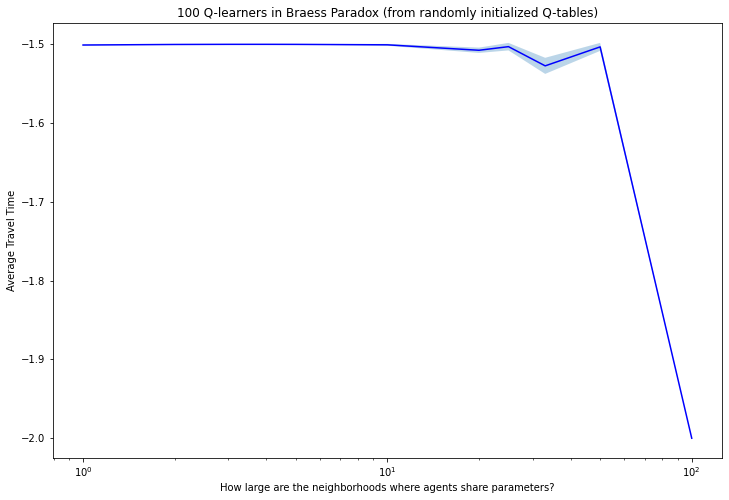

In [465]:
plt.figure(figsize=(12, 8))
plt.plot(results_dict.keys(), y_vals, color="blue")
plt.fill_between(results_dict.keys(), y_vals+y_std, y_vals-y_std, alpha=0.3)
plt.title("100 Q-learners in Braess Paradox (from randomly initialized Q-tables)")
plt.xlabel("How large are the neighborhoods where agents share parameters?")
plt.ylabel("Average Travel Time")
plt.xticks(ticks=[0, 20, 80, 100], labels=["1:fully independent", "20:small neighborhoods", "80:large neighborhoods", "100:identical models"])
# plt.axhline(y = -1.5)
# plt.axhline(y = -2)
plt.xscale("log")
plt.savefig(f"average_{experiment_type}_neighbours_{network_type}.png")

In [466]:
y_variance = np.array([np.mean([rep[-1000:-1].std() for rep in repetitions.values()]) for repetitions in results_dict.values()])
y_variance_std = np.array([np.std([rep[-1000:-1].std() for rep in repetitions.values()]) for repetitions in results_dict.values()])

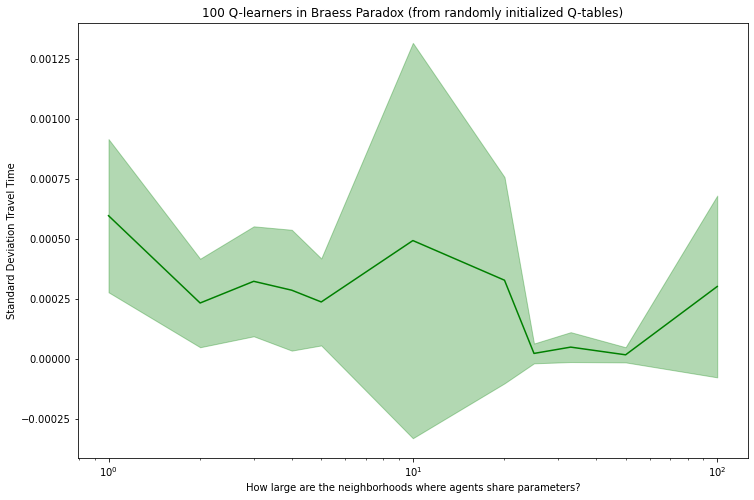

In [467]:
plt.figure(figsize=(12, 8))
plt.plot(results_dict.keys(), y_variance, color="green")
plt.fill_between(results_dict.keys(), y_variance+y_variance_std, y_variance-y_variance_std, color="green", alpha=0.3)
plt.title("100 Q-learners in Braess Paradox (from randomly initialized Q-tables)")
plt.xlabel("How large are the neighborhoods where agents share parameters?")
plt.ylabel("Standard Deviation Travel Time")
plt.xticks(ticks=[0, 20, 80, 100], labels=["1:fully independent", "20:small neighborhoods", "80:large neighborhoods", "100:identical models"])
# plt.axhline(y = -1.5)
# plt.axhline(y = -2)
plt.xscale("log")
plt.savefig(f"std_{experiment_type}_neighbours_{network_type}.png")

In [470]:
y_series = np.array([np.mean([rep for rep in repetitions.values()], axis=0) for repetitions in results_dict.values()])
y_series_std = np.array([np.std([rep for rep in repetitions.values()], axis=0) for repetitions in results_dict.values()])

In [469]:
N = 100 # smoothing parameter
y_series = np.convolve(y_series, np.ones(N)/N, mode='valid')
y_series_std = np.convolve(y_series_std, np.ones(N)/N, mode='valid')

ValueError: object too deep for desired array

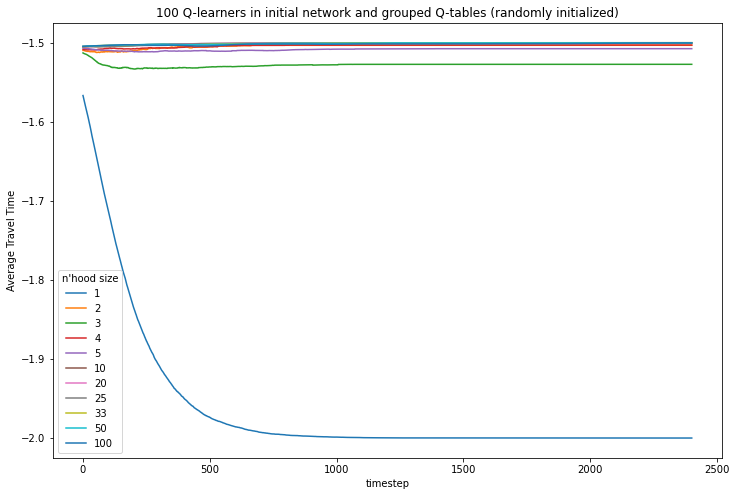

In [471]:
plt.figure(figsize=(12, 8))
for x in range(y_series.shape[0]):
    plt.plot(np.convolve(y_series[x], np.ones(N)/N, mode='valid'), label=x_vals[x])

# plt.fill_between(np.arange(N_ITER), y_series+y_series_std, y_series-y_series_std, alpha=0.3)
plt.title(f"100 Q-learners in {network_type} network and {experiment_type} Q-tables (randomly initialized)")
plt.xlabel("timestep")
plt.ylabel("Average Travel Time")
# plt.xticks(ticks=[0, 20, 80, 100], labels=["1:fully independent", "20:small neighborhoods", "80:large neighborhoods", "100:identical models"])
# plt.axhline(y = -1.5)
# plt.axhline(y = -2)
# plt.xscale("log")
plt.legend(title="n'hood size")
plt.savefig(f"timeseries_{experiment_type}_neighbours_{network_type}.png")

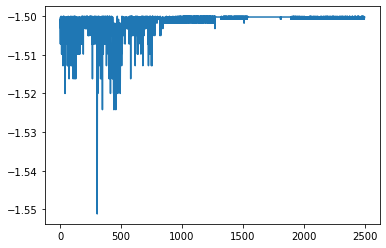

In [427]:
plt.plot(results_dict[2][1])

In [386]:
name = f"results_{experiment_type}_neighbours_{network_type}.pkl"
if os.path.exists(name):
    print("error name exists")
else:
    with open(name, "wb") as file:
        pickle.dump(results_dict, file)

In [457]:
experiment_type = "grouped"
network_type = "initial"
name = f"results_{experiment_type}_neighbours_{network_type}.pkl"
with open(name, "rb") as file:
    results_dict = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'results_grouped_neighbours_initial.pkl'

In [429]:
results_dict

{1: {0: array([-1.5   , -1.5018, -1.5018, ..., -1.5   , -1.5   , -1.5   ]),
  1: array([-1.5002, -1.5018, -1.5008, ..., -1.5   , -1.5   , -1.5   ]),
  2: array([-1.5008, -1.5032, -1.5128, ..., -1.5   , -1.5   , -1.5   ]),
  3: array([-1.5128, -1.5008, -1.5162, ..., -1.5   , -1.5   , -1.5   ]),
  4: array([-1.5008, -1.5   , -1.5162, ..., -1.5   , -1.5   , -1.5   ]),
  5: array([-1.5002, -1.5018, -1.5072, ..., -1.5   , -1.5   , -1.5   ]),
  6: array([-1.5032, -1.505 , -1.5128, ..., -1.5   , -1.5   , -1.5   ]),
  7: array([-1.5   , -1.5162, -1.5288, ..., -1.5   , -1.5   , -1.5   ]),
  8: array([-1.5002, -1.5072, -1.5032, ..., -1.5   , -1.5   , -1.5   ]),
  9: array([-1.5   , -1.5   , -1.5018, ..., -1.5   , -1.5   , -1.5   ])},
 2: {0: array([-1.5162, -1.5032, -1.5098, ..., -1.5008, -1.5002, -1.5008]),
  1: array([-1.5098, -1.5   , -1.5008, ..., -1.5002, -1.5002, -1.5002]),
  2: array([-1.5018, -1.505 , -1.5018, ..., -1.5   , -1.5002, -1.5   ]),
  3: array([-1.5242, -1.5002, -1.505 , ..., 